# Airbnb 短租数据集分析 —— 阿里云天池大数据

In [5]:
import numpy as np
import pandas as pd
import pymysql
from wordcloud import WordCloud, STOPWORDS
import jieba
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
%matplotlib inline

In [ ]:
text = df.name
text_charInfo = chardet.detect(text)
print(text_charInfo)
# 结果
{'encoding': 'UTF-8-SIG', 'confidence': 1.0, 'language': ''}
text = open('WorkSpace/Airbnb/sourceFile/listings.csv'),encoding='UTF-8-SIG').read()

In [64]:
import os
print(os.path.abspath(','))

C:\Users\84605\WorkSpace\Airbnb\,


In [6]:
# jieba 中文分词
text = open(('D:/workspace/python/DAB/Airbnb/Source_file/listings.csv'),encoding='UTF-8-SIG').read()

isCN = 1

def jiebaclearText(text):
    mywordlist = []
    seg_list = jieba.cut(text, cut_all=False)
    liststr="/ ".join(seg_list)
    f_stop = open(stopwords_path)
    try:
        f_stop_text = f_stop.read( )
        f_stop_text=unicode(f_stop_text,'utf-8')
    finally:
        f_stop.close( )
    f_stop_seg_list=f_stop_text.split('\n')
    for myword in liststr.split('/'):
        if not(myword.strip() in f_stop_seg_list) and len(myword.strip())>1:
            mywordlist.append(myword)
    return ''.join(mywordlist)

if isCN:
    text = jiebaclearText(text)


Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\84605\AppData\Local\Temp\jieba.cache
Loading model cost 0.975 seconds.
Prefix dict has been built successfully.


NameError: name 'f_stop' is not defined

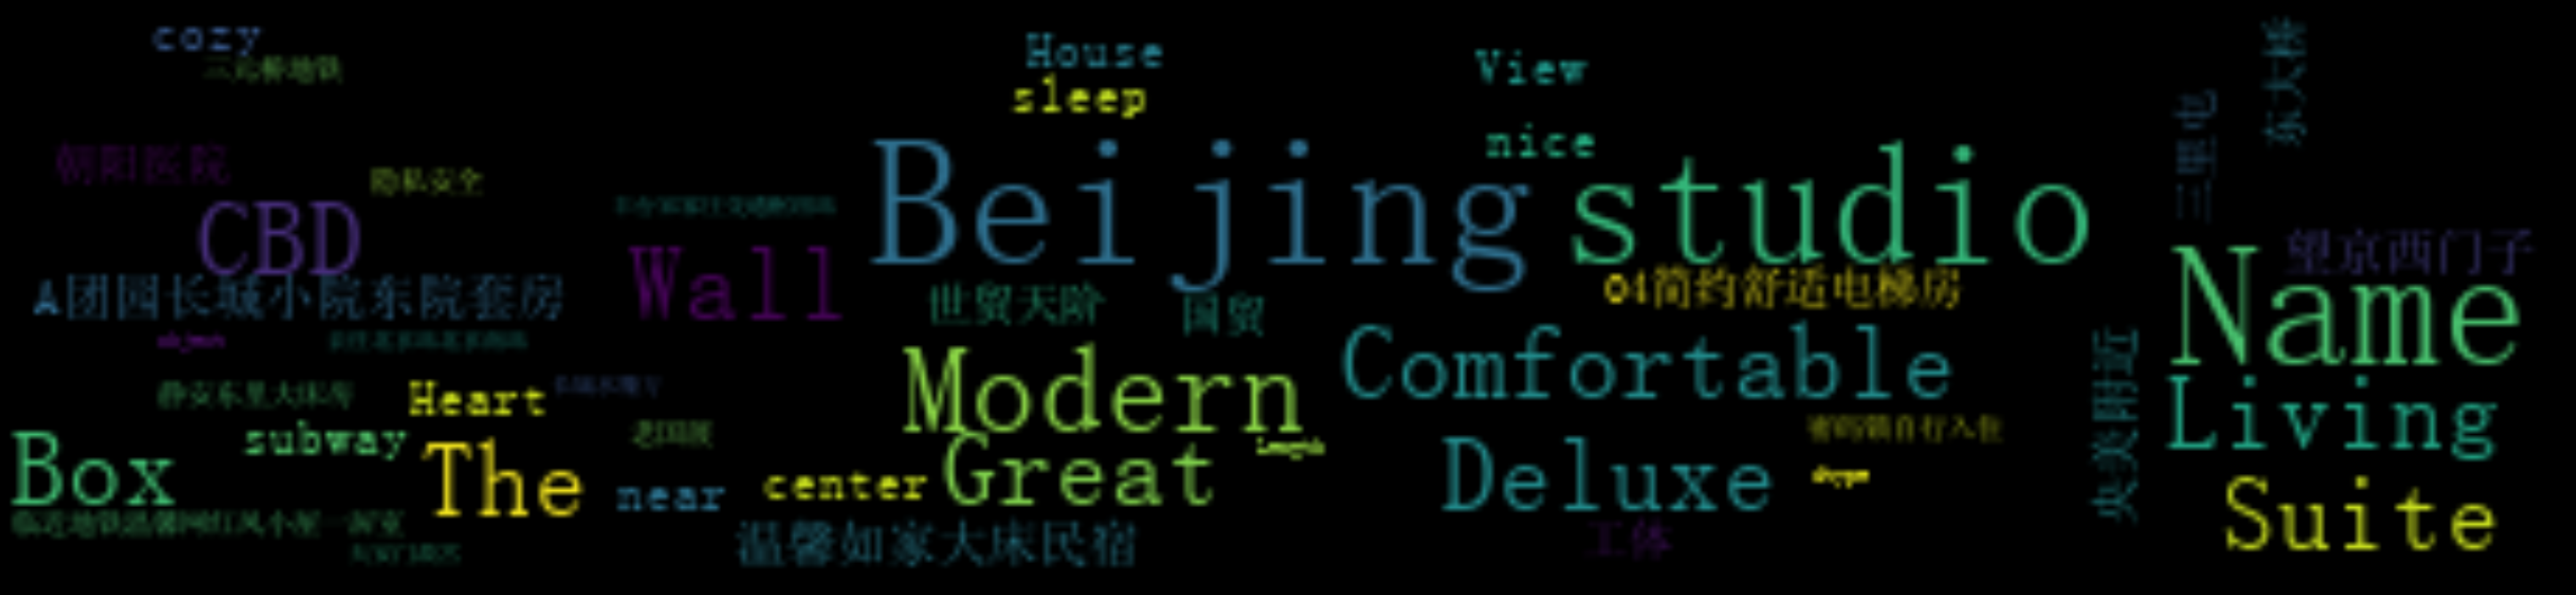

In [56]:
# 读取背景图片
background_Image = np.array(Image.open('D:/workspace/python/tools/language/OIP.jfif'))

wc = WordCloud(
    font_path="simsun.ttf",
    margin = 2, # 设置页面边缘
    mask = background_Image,
    max_words = 200, # 最多词个数
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
#存储图像
wc.to_file('1900pro1.png')
# 显示图像
plt.imshow(wc, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

## 1 数据预处理
### 1.1 将数据导入Mysql

### 1.2 查看数据

In [14]:
dbconn=pymysql.connect(
  host="localhost",
  database="airbnb",
  user="root",
  password="root",
  port=3306,
  charset='utf8'
 )
  
#sql语句
sqlcmd="select * from listing"
  
#利用pandas 模块导入mysql数据
df=pd.read_sql(sqlcmd,dbconn)
#取前5行数据
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,44054,Modern and Comfortable Living in CBD,192875,East Apartments,0,朝阳区 / Chaoyang,39.8950,116.452,Entire home/apt,792,1,89,00:20:19,0.85,9,341
1,100213,The Great Wall Box Deluxe Suite A团园长城小院东院套房,527062,Joe,0,密云县 / Miyun,40.6843,117.172,Private room,1201,1,2,00:20:17,0.10,4,0
2,128496,Heart of Beijing: House with View 2,467520,Cindy,0,东城区,39.9321,116.422,Entire home/apt,389,3,259,00:20:19,2.70,1,93
3,161902,cozy studio in center of Beijing,707535,Robert,0,东城区,39.9336,116.436,Entire home/apt,376,1,26,00:20:16,0.28,5,290
4,162144,"nice studio near subway, sleep 4",707535,Robert,0,朝阳区 / Chaoyang,39.9367,116.438,Entire home/apt,537,1,37,00:20:18,0.40,5,352


#### 1.2.1 发现neighbourhood_group值为空，相邻列neighbourhood数据完整，依据neighbourhood列为其赋值

In [17]:
lst_nei = list(set(df['neighbourhood']))
lst_nei

['房山区',
 '丰台区 / Fengtai',
 '通州区 / Tongzhou',
 '平谷区 / Pinggu',
 '怀柔区 / Huairou',
 '大兴区 / Daxing',
 '延庆县 / Yanqing',
 '石景山区',
 '昌平区',
 '门头沟区 / Mentougou',
 '密云县 / Miyun',
 '海淀区',
 '顺义区 / Shunyi',
 '东城区',
 '西城区',
 '朝阳区 / Chaoyang']

#### 1.2.2 room_type有三种类型，且不是有序分类变量，是无序，且为文字，为后面好建模，新建一列‘roomtype_group’，并依据room_type赋值

In [18]:
lst_r = list(set(df['room_type']))
lst_r

['Private room', 'Shared room', 'Entire home/apt']

## 2 预分析
### 1.2 查看各项均值

In [4]:
df.describe()[['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']]

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,28452.000000,28452.000000,28452.000000,17294.000000,28452.000000,28452.000000
mean,611.203325,2.729685,7.103156,1.319757,12.818290,220.342120
std,1623.535077,17.920932,16.815067,1.581243,29.261321,138.430677
min,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,235.000000,1.000000,0.000000,0.290000,2.000000,87.000000
50%,389.000000,1.000000,1.000000,0.800000,5.000000,209.000000
75%,577.000000,1.000000,6.000000,1.750000,11.000000,361.000000
max,68983.000000,1125.000000,322.000000,20.000000,222.000000,365.000000


#### calculated_host_listings_count: 
当天一天内产生消费的房屋记录中，房东人均拥有12.8处正在被租用的房产
其中最多的拥有222间在昨天同时租出，房东host_id为‘美婷’
第二多为210间的‘兴伟’
第三为115间的‘海梅’

In [6]:
df.head(5)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,44054,Modern and Comfortable Living in CBD,192875,East Apartments,NaN,朝阳区 / Chaoyang,39.89503,116.45163,Entire home/apt,792,1,89,2019-03-04,0.85,9,341
1,100213,The Great Wall Box Deluxe Suite A团园长城小院东院套房,527062,Joe,NaN,密云县 / Miyun,40.68434,117.17231,Private room,1201,1,2,2017-10-08,0.10,4,0
2,128496,Heart of Beijing: House with View 2,467520,Cindy,NaN,东城区,39.93213,116.42200,Entire home/apt,389,3,259,2019-02-05,2.70,1,93
3,161902,cozy studio in center of Beijing,707535,Robert,NaN,东城区,39.93357,116.43577,Entire home/apt,376,1,26,2016-12-03,0.28,5,290
4,162144,"nice studio near subway, sleep 4",707535,Robert,NaN,朝阳区 / Chaoyang,39.93668,116.43798,Entire home/apt,537,1,37,2018-08-01,0.40,5,352


In [12]:
subsets = df[['id', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type','price', 'minimum_nights', 'number_of_reviews','last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']]
'''pd.open(WorkSpace/Airbnb/sourceFile/spss_raw.csv, 'w')'''
import csv
with open('D:/workspace/python/pythonDataAnalyzBasic/Airbnb_DataAnalysis/sp.csv', 'w') as csvfile:
    '''reader = csv.reader(csvfile)'''
    for line in subsets:
        print(line)

id
host_id
host_name
neighbourhood_group
neighbourhood
latitude
longitude
room_type
price
minimum_nights
number_of_reviews
last_review
reviews_per_month
calculated_host_listings_count
availability_365


In [15]:
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
       'minimum_nights', 'number_of_reviews', 'last_review',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')

In [7]:
'''subsets = df[['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']]

fig,axes = plt.subplots(len(subsets),1,figsize=(20,10))
for i,subset in enumerate(subsets):
    sns.boxplot(df[subset], ax=axes[i],whis=2,orient='h')'''

"subsets = df[['price', 'minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365']]\n\nfig,axes = plt.subplots(len(subsets),1,figsize=(20,10))\nfor i,subset in enumerate(subsets):\n    sns.boxplot(df[subset], ax=axes[i],whis=2,orient='h')"

In [ ]:
# 小于1000的price值 - regular price - reg_p\n",
reg_p = []
for pr in df['price']:
    if pr < 1000:
        reg_p.append(pr)
'''
len(reg_p) = 25744
len(reg_p) / len(list_df['price'])
0.9048221566146493
小于1000的price值占全部price的90.48%
'''

sns.boxplot(reg_p, orient='h')
plt.show()

In [ ]:
df1 = df[['price', 'minimum_nights', 'number_of_reviews', 'availability_365']]
# 抽取几列出来作为一个纯数字的新df，看相关关系\n",
# scatter_matrix(df1, alpha=0.5, diagonal='kde')

In [ ]:
plt.scatter(df['latitude'], df['longitude'], cmap='Reds', alpha=0.5)

In [4]:
lst_r = list(set(df['room_type']))
lst_r

['Entire home/apt', 'Shared room', 'Private room']

In [ ]:
df.index

In [ ]:
dict_nei = dict(enumerate(lst_nei))
for i,neibr in enumerate(lst_nei):
    for j in df.index:
        if df['neighbourhood'][j] = dict_nei[i]:
            df['neighbourhood_group'][j] = i

In [ ]:
data['neighbourhood']

## 回归分析


## 1. 新建多元线性回归
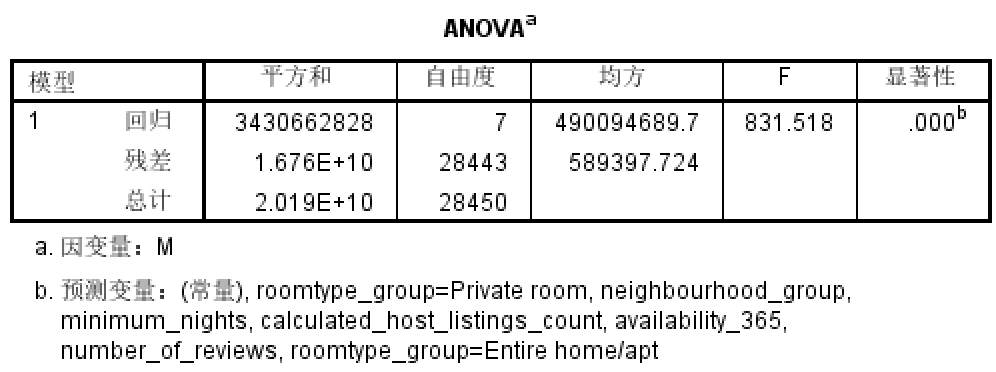
自变量中存在无序分类变量——房型：<br/>整租(Entire home/Apt)、</br>
                             <br/>单间(Private room)、</br>
                             <br/>合租(Shared room)</br>        ——(有序分类变量可以作为多元线性回归因变量)
    需要考虑将其进行哑变量处理
### 1.1. 哑变量
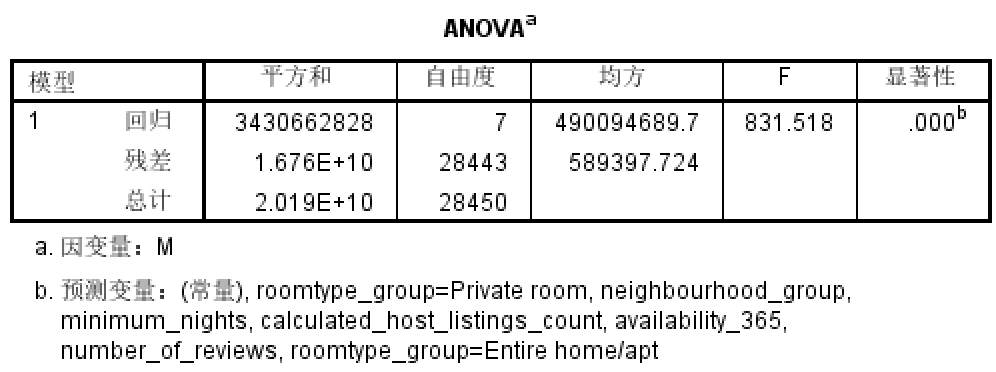
### 1.2. R^2
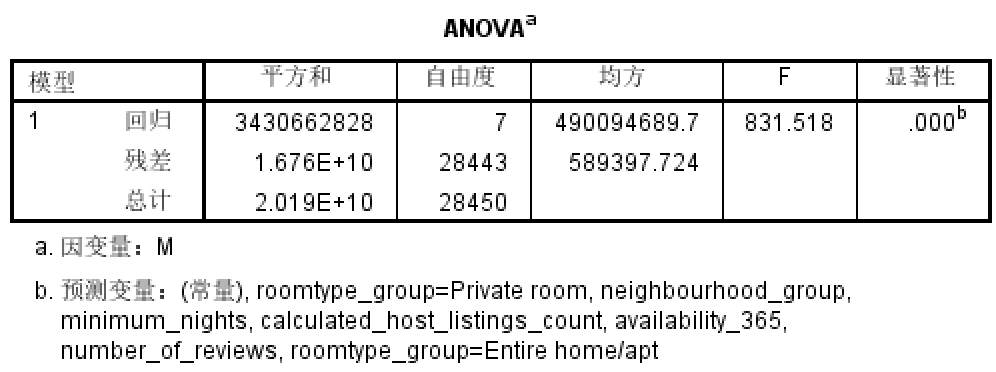
R方为0.17，拟合度不佳
### 1.3. ANOVA方差检验
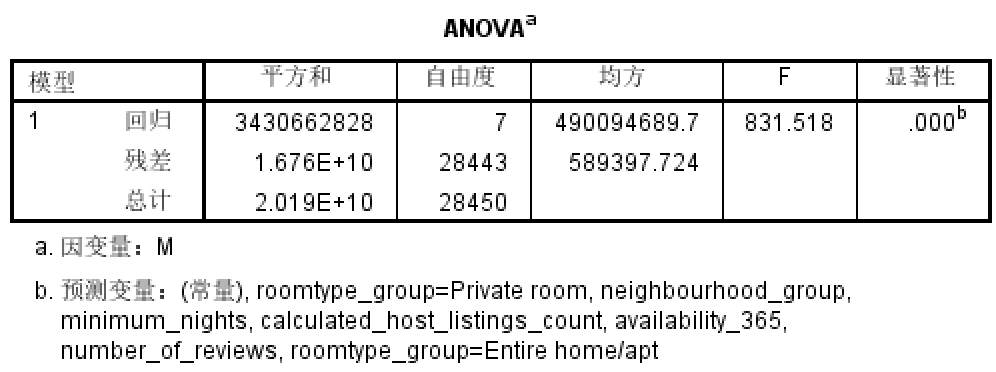

### 残差分析
大部分数据在正负3个标准差之内，且与标准化后的预测值无异常相关，残差分析通过

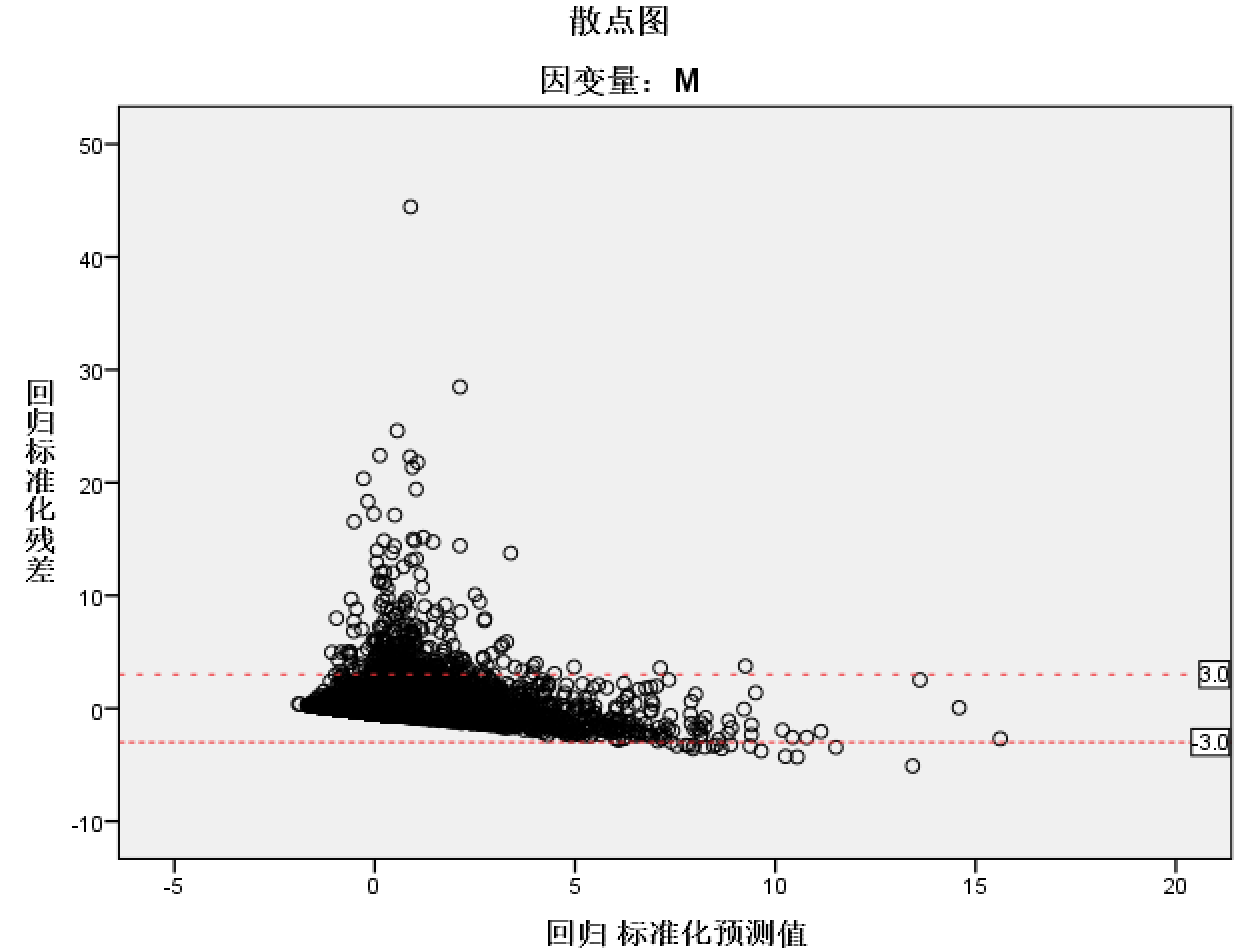